<a href="https://colab.research.google.com/github/cxbxmxcx/GenReality/blob/master/GEN_6_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title INSTALLS
!pip install livelossplot --quiet

In [ ]:
#@title IMPORTS 
#@markdown run to import modules
import os
import numpy as np
import math
import itertools
import scipy
import sys
import time
import datetime

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torch.autograd as autograd
from torchvision.utils import make_grid

import torch.nn as nn
import torch.nn.functional as F
import torch

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from livelossplot import PlotLosses

In [ ]:
#@title HYPERPARAMETERS 
dataset_name = "img_align_celeba" #@param ["img_align_celeba"]
selected_attr_1 = "Blond_Hair" #@param ["Attractive","Bald","Bangs","Big_Lips","Big_Nose","Black_Hair","Blond_Hair","Brown_Hair","Eyeglasses","Goatee","Gray_Hair","Male","No_Beard","Sideburns","Smiling","Young"]
selected_attr_2 = "Black_Hair" #@param ["Attractive","Bald","Bangs","Big_Lips","Big_Nose","Black_Hair","Brown_Hair","Eyeglasses","Goatee","Gray_Had_Hair","Blurry","Broir","Male","No_Beard","Sideburns","Smiling","Young"]
selected_attr_3 = "Brown_Hair" #@param ["Attractive","Bald","Bangs","Big_Lips","Big_Nose","Black_Hair","Blond_Hair","Brown_Hair","Eyeglasses","Goatee","Gray_Hair","Male","No_Beard","Sideburns","Smiling","Young"]
selected_attr_4 = "Male" #@param ["Attractive","Bald","Bangs","Big_Lips","Big_Nose","Black_Hair","Blond_Hair","Brown_Hair","Eyeglasses","Goatee","Gray_Hair","Male","No_Beard","Sideburns","Smiling","Young"]
selected_attr_5 = "Young" #@param ["Attractive","Bald","Bangs","Big_Lips","Big_Nose","Black_Hair","Blond_Hair","Brown_Hair","Eyeglasses","Goatee","Gray_Hair","Male","No_Beard","Sideburns","Smiling","Young"]

attributes = [selected_attr_1,selected_attr_2,selected_attr_3,selected_attr_4,selected_attr_5]
print(attributes)
class Hyperparameters(object):
  def __init__(self, **kwargs):
    self.__dict__.update(kwargs)

datasets = { "img_align_celeba" : { "url" : 'https://www.dropbox.com/s/5hznryk2m0qxs2m/img_align_celeba.zip?dl=1',
                          "annotations" : "https://www.dropbox.com/s/vsxuglogmz4ezcf/list_attr_celeba.txt?dl=1",
                          "train_mode" : "train",
                          "test_mode" : "test"}           
            }

hp = Hyperparameters(
    epoch=0,
    n_epochs=5,
    batch_size=64,    
    train_split=.05,
    dataset_name=dataset_name,
    dataset_url=datasets[dataset_name]["url"],
    dataset_annotations=datasets[dataset_name]["annotations"],
    dataset_train_mode=datasets[dataset_name]["train_mode"],
    dataset_test_mode=datasets[dataset_name]["test_mode"], 
    selected_attrs=attributes,   
    lr=.0002,
    b1=.5,
    b2=0.999,     
    n_cpu=8,
    img_size=128,
    channels=3,     
    sample_interval=150 
    )

img_root_folder = 'images'
os.makedirs(img_root_folder, exist_ok=True)
image_folder = img_root_folder + "/%s" % hp.dataset_name 
print(f"Image data folders constructed {image_folder}")
os.makedirs(image_folder, exist_ok=True)

['Blond_Hair', 'Black_Hair', 'Brown_Hair', 'Male', 'Young']
Image data folders constructed images/img_align_celeba


In [ ]:
#@title DOWNLOAD IMAGES
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile
zipurl = hp.dataset_url
with urlopen(zipurl) as zipresp:
    with ZipFile(BytesIO(zipresp.read())) as zfile:        
        zfile.extractall(img_root_folder)
        print(f"Downloaded & Extracted {zipurl}")

Downloaded & Extracted https://www.dropbox.com/s/5hznryk2m0qxs2m/img_align_celeba.zip?dl=1


In [ ]:
#@title DOWNLOAD ANNOTATIONS
!pip install wget
import wget
wget.download(hp.dataset_annotations,image_folder)

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=d21ebe3fb830ae7984cc4def9d4209521a2d63643cf6f4793fe67feb23639c2c
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


'images/img_align_celeba/list_attr_celeba.txt'

In [ ]:
#@title IMAGE DOWNLOAD HELPERS AND FORATTERS
import glob
import random
import os
from torch.utils.data import Dataset
from PIL import Image

class CelebADataset(Dataset):
    def __init__(self, root, transforms_=None, mode="train", attributes=None, train_split=.9):
        self.transform = transforms.Compose(transforms_)
        self.selected_attrs = attributes
        self.label_path = glob.glob("%s/*.txt" % root)[0]
        self.annotations = self.get_annotations()
        self.files = sorted([f"{root}/{file}" for file in self.annotations])
        #self.files = sorted(glob.glob("%s/*.jpg" % root))        
        self.files = self.files[0:int(len(self.files)*train_split)] if mode == "train" else self.files[int(len(self.files)*(1.0-train_split)):]
        print(len(self.files))               

    def get_annotations(self):
        """Extracts annotations for CelebA"""
        annotations = {}
        lines = [line.rstrip() for line in open(self.label_path, "r")]
        self.label_names = lines[1].split()
        for _, line in enumerate(lines[2:]):
            filename, *values = line.split()
            labels = []
            for attr in self.selected_attrs:
                idx = self.label_names.index(attr)
                labels.append(1 * (values[idx] == "1"))
            annotations[filename] = labels
        return annotations

    def __getitem__(self, index):
        filepath = self.files[index % len(self.files)]
        filename = filepath.split("/")[-1]
        img = self.transform(Image.open(filepath))
        label = self.annotations[filename]
        label = torch.FloatTensor(np.array(label))

        return img, label

    def __len__(self):
        return len(self.files)

In [ ]:
#@title IMAGE VISUALIZER HELPERS
def imshow(img,size=10):
  img = img / 2 + 0.5     
  npimg = img.numpy()
  npimg = np.clip(npimg, 0, 1.0)
  plt.figure(figsize=(size, size))
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

def to_img(x):    
    x = x.view(x.size(0)*2, hp.channels, hp.img_size, hp.img_size)
    return x

import matplotlib.image as mpimg
def visualise_output(path, x, y):
    img = mpimg.imread(path)
    plt.figure(figsize=(x,y))
    plt.imshow(img)  
    plt.show()

In [ ]:
#@title CONFIGURE DATALOADERS
# Configure dataloaders
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

train_transforms = [
    transforms.Resize(int(1.25 * hp.img_size), Image.BICUBIC),
    transforms.CenterCrop(hp.img_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
]

dataloader = DataLoader(
    CelebADataset(
        image_folder, transforms_=train_transforms,
        mode="train", 
        attributes=hp.selected_attrs, 
        train_split=hp.train_split
    ),
    batch_size=hp.batch_size,
    shuffle=True,
    num_workers=hp.n_cpu,
)

val_transforms = [
    transforms.Resize(int(1.25 * hp.img_size), Image.BICUBIC),
    transforms.CenterCrop(hp.img_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
]

val_dataloader = DataLoader(
    CelebADataset(
        image_folder, transforms_=val_transforms, mode="val", attributes=hp.selected_attrs
    ),
    batch_size=10,
    shuffle=True,
    num_workers=1,
)

10129
182340


['Young']


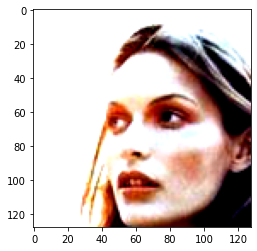

['Blond_Hair', 'Young']


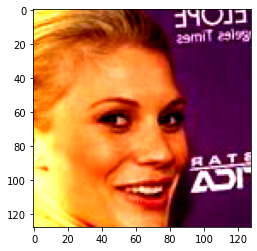

['Black_Hair', 'Male', 'Young']


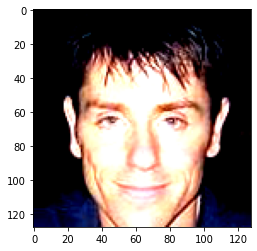

['Young']


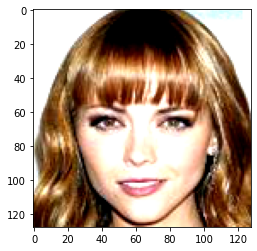

['Brown_Hair', 'Young']


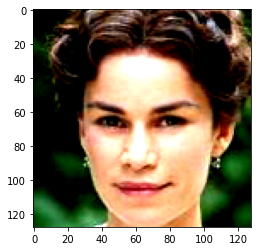

[]


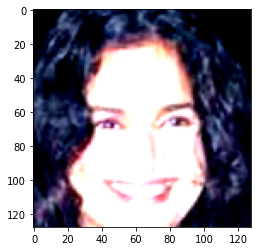

['Brown_Hair', 'Young']


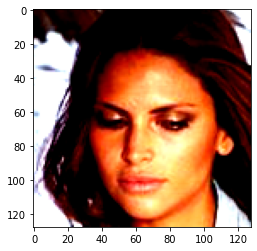

['Male']


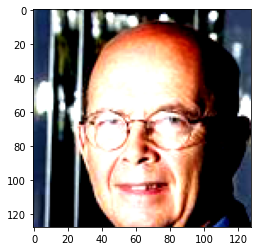

['Male', 'Young']


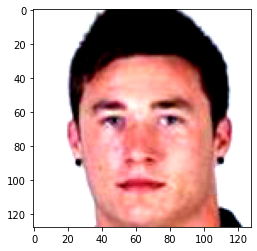

['Brown_Hair', 'Male']


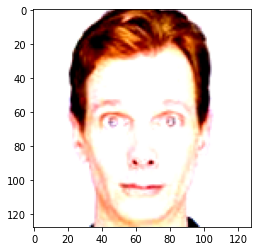

['Black_Hair', 'Male', 'Young']


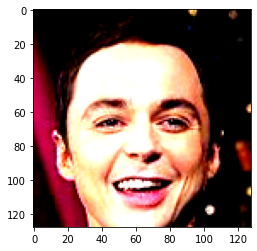

['Blond_Hair', 'Young']


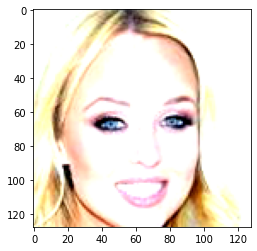

['Male', 'Young']


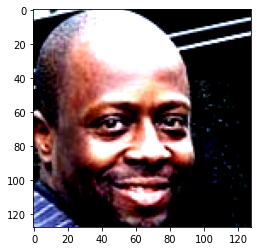

['Blond_Hair']


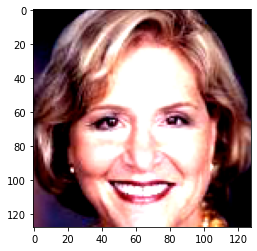

['Blond_Hair', 'Young']


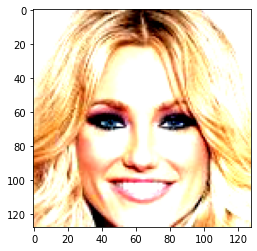

['Black_Hair', 'Male']


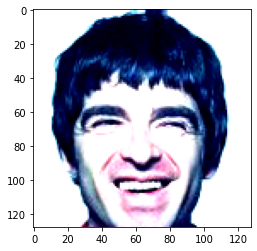

['Black_Hair', 'Male', 'Young']


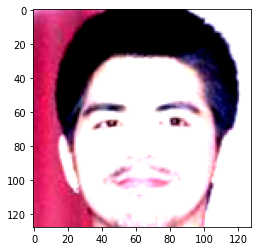

['Brown_Hair', 'Young']


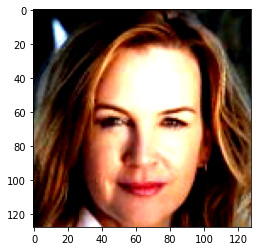

['Black_Hair', 'Young']


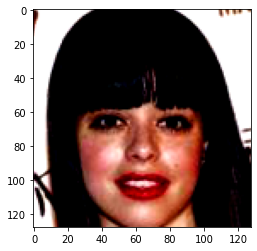

['Male']


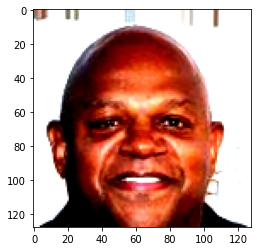

['Blond_Hair', 'Young']


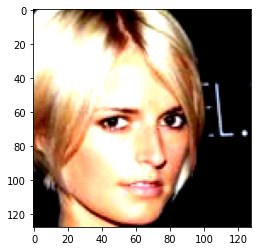

['Brown_Hair', 'Male', 'Young']


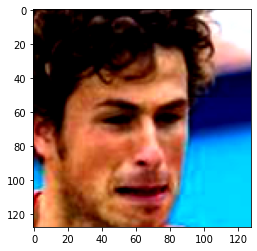

['Black_Hair', 'Male', 'Young']


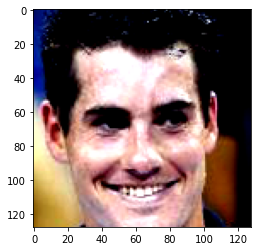

['Male']


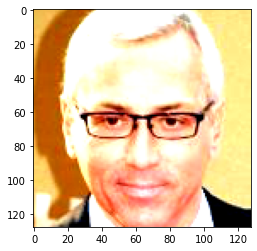

['Male']


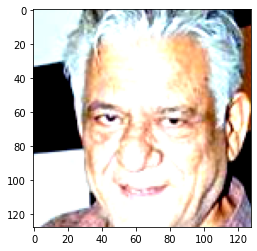

['Male', 'Young']


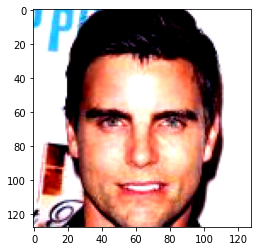

['Young']


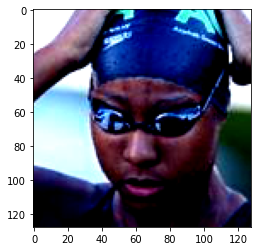

['Blond_Hair', 'Young']


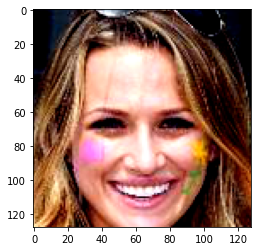

['Male', 'Young']


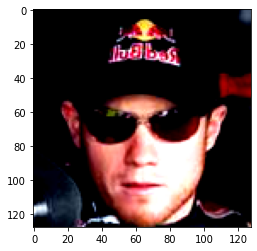

['Black_Hair', 'Male', 'Young']


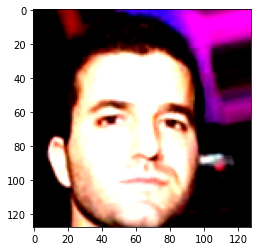

['Brown_Hair', 'Young']


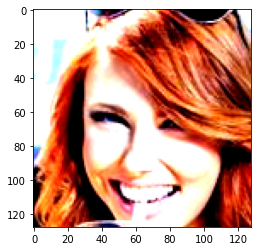

['Brown_Hair', 'Young']


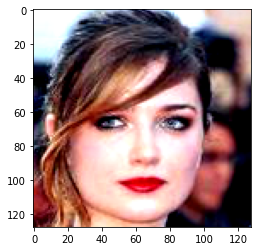

IndexError: ignored

In [ ]:
#@title VISUALING SAMPLE DATA { run: "auto" }
pic_size = 4 #@param {type:"integer"} {type:"slider", min:1, max:30, step:1}

dataiter = iter(dataloader)
(imgs, labels) = dataiter.next()
for i in range(hp.batch_size):
  print([hp.selected_attrs[j] for j, label in enumerate(labels[i]) if label > 0])
  imshow(make_grid(imgs[i]), size=pic_size)


In [ ]:
#@title SETUP AND BUILD THE MODEL

cuda = True if torch.cuda.is_available() else False
print("Using CUDA" if cuda else "Not using CUDA")

classes = hp.selected_attrs
## Load the model based on VGG19
model = torchvision.models.vgg19(pretrained=True)

## freeze the layers
for param in model.parameters():
   param.requires_grad = False

# Modify the last layer
number_features = model.classifier[6].in_features
features = list(model.classifier.children())[:-1] # Remove last layer
features.extend([torch.nn.Linear(number_features, len(classes))])
model.classifier = torch.nn.Sequential(*features)

loss_fn = torch.nn.CrossEntropyLoss()

if cuda:
  model.cuda()
  loss_fn.cuda()

print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=hp.lr, betas=(hp.b1, hp.b2))

Using CUDA
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(

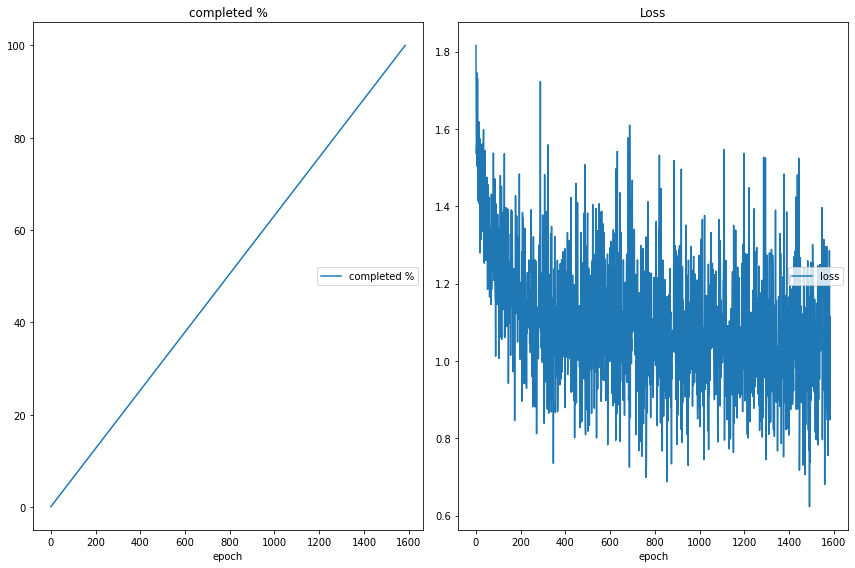

completed %
	completed %      	 (min:    0.063, max:  100.000, cur:  100.000)
Loss
	loss             	 (min:    0.623, max:    1.816, cur:    1.113)
Training complete in 13m 59s


In [ ]:
#@title TRAINING
since = time.time()
liveloss = PlotLosses()
hist = {}
batch=0
completed = 0
for epoch in range(hp.n_epochs):
    print('Epoch {}/{}'.format(epoch, hp.n_epochs - 1))
    print('-' * 10)

    #set model to trainable
    # model.train()

    train_loss = 0

    # Iterate over data.
    for i, data in enumerate(dataloader):
        inputs , labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()

        optimizer.zero_grad()
      
        with torch.set_grad_enabled(True):
            outputs  = model(inputs)
            loss = loss_fn(outputs, torch.max(labels, 1)[1])            

        loss.backward()
        optimizer.step()

        train_loss = loss.item() 
        hist['loss'] = train_loss
        batch = batch + 1
        completed = (1 - ((hp.n_epochs * len(dataloader)-batch) / (hp.n_epochs * len(dataloader))) ) * 100
        hist['completed %'] = completed
        liveloss.update(hist)
        liveloss.send()    
      
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

Predicted: Blond_Hair Truth: ['Blond_Hair', 'Brown_Hair', 'Young']


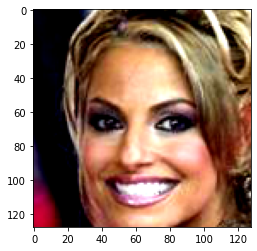

Predicted: Black_Hair Truth: ['Black_Hair', 'Young']


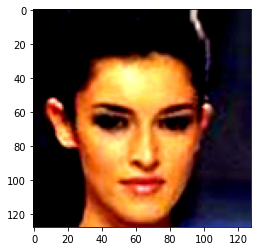

Predicted: Black_Hair Truth: ['Male']


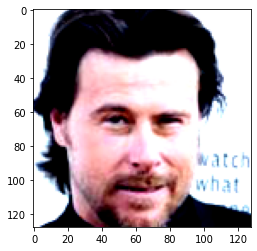

Predicted: None Truth: ['Young']


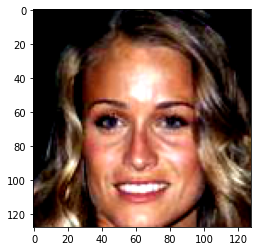

Predicted: None Truth: ['Blond_Hair', 'Young']


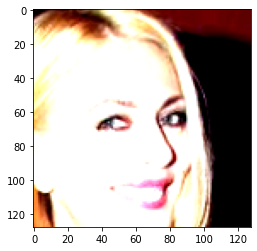

Predicted: Black_Hair Truth: ['Black_Hair', 'Male']


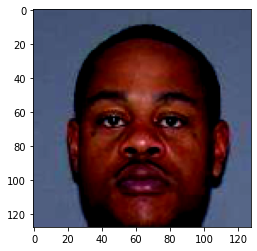

Predicted: Blond_Hair Truth: ['Male']


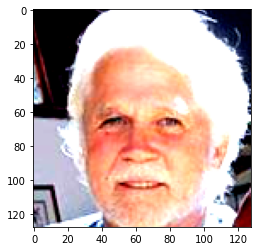

Predicted: Brown_Hair Truth: ['Brown_Hair', 'Young']


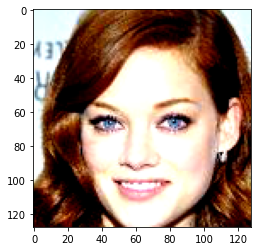

Predicted: Blond_Hair Truth: ['Blond_Hair', 'Young']


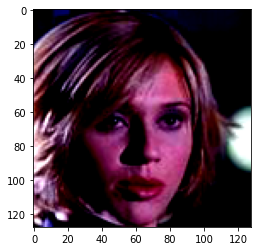

Predicted: None Truth: ['Male', 'Young']


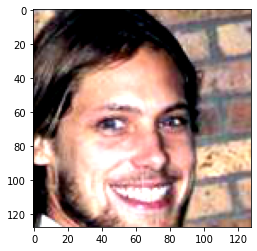

In [ ]:
num_images = 6
was_training = model.training
model.eval()

with torch.no_grad():
    (inputs, labels) = next(iter(val_dataloader))
    inputs = inputs.cuda() 
    outputs = model(inputs)     
    preds = torch.where(outputs > .5, 1, 0)       
    for i in range(len(inputs)):
      pred_label = [hp.selected_attrs[i] for i,label in enumerate(preds[i]) if label > 0]
      truth_label = [hp.selected_attrs[i] for i,label in enumerate(labels[i]) if label > 0]
      print(f"Predicted: {(pred_label[0] if pred_label else None)} Truth: {truth_label}")
      imshow(make_grid(inputs[i].cpu()), size=pic_size)                     
    model.train(mode=was_training)